This is going to be the similar mass case with circular orbit and then implement Df equation with that


How this Jupyter Notebook will look like:
- Initialize the packets
- initial conditions
- dictate the circular orbit
- forloop
- effective energy plot (coming soon)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import solve_ivp
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const
import math

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 12 
#this is to make the font of the plots to be Times New Roman

This is the tests that were done in Kris' github:

In [4]:
a_0 = 2.95 
b_0 = 0.596
mstar_tot = 1e11 * u.Msun
r_eff = (a_0*(mstar_tot/(1.e6*u.Msun))**b_0)* u.pc

print(r_eff)

2817.2281287632354 pc


In [5]:
m1 = 4e8 * u.Msun

rb = (m1/mstar_tot)**(1./3.)*r_eff
print("Binary radius is:", rb)
dyn_hard = (((rb/r_eff)**3)*r_eff).to(u.pc)
print(dyn_hard)

Binary radius is: 447.20708952331626 pc
11.268912515052946 pc


In [6]:
# region Code Snippet 1: IC's
G = const.G.to(u.pc**3/(u.kg*u.yr**2)) #change the innate time to years
m_gal = 1e11 * const.M_sun
#Masses
m1=4e8 * const.M_sun #mass of black hole A 
m2=4e8 * const.M_sun #mass of black hole B


sep = 430*u.pc
r1_initial=[((sep/2.).value),0,0] * u.pc
r2_initial=[-((sep/2.).value),0,0] * u.pc
#To arrays

r1=np.array(r1_initial,dtype="float64") * u.pc
r2=np.array(r2_initial,dtype="float64") * u.pc

#Semi-major axis 
a = (0.5 * (sep))

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)

#orbital veloctiy
# orb_v = (np.sqrt(const.G*(m1+m2)/a)).to(u.km/u.s) #added with Kris' source
# v = np.sqrt((const.G * (m1)) / r.to(u.m)).to(u.km/u.s)
v_circ = (np.sqrt((G*m1*(sep/2))/(sep)**2)).value
print(r1)
#V_i
v1_initial=[0,v_circ, 0] *u.pc/u.yr
v2_inital=[0,-v_circ,0] *u.pc/u.yr #km/s

#To arrays
v1=np.array(v1_initial,dtype="float64") *u.pc/u.yr
v2=np.array(v2_inital,dtype="float64") *u.pc/u.yr
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)




[215.   0.   0.] pc


In [7]:
print(m1)

7.953639482792204e+38 kg


Functions

In [ ]:
def velocity_dispersion(m_gal_):
    """Calculate velocity dispersion"""
    return ((10**2.2969) * (m_gal_/(1e11 * u.Msun))**0.299 * (u.km/u.s)).to(u.pc/u.yr)

def coulomb_logarithm(r_com_, o_, G, m_):
    """Calculate Coulomb logarithm """
    x = (r_com_ * o_**2 / (G * m_)).decompose()
    return math.log10(x.value)

def dynamical_friction_a(r_com_, v_rel_, ln_A_, G, m_):
    """Calculate dynamical friction acceleration for a single body"""
    v_mag = np.linalg.norm(v_rel_)
    unit_v = v_rel_ / v_mag
    a_df_mag = 0.428 * ln_A_ * (G * m_ / r_com_**2)
    return (-a_df_mag * unit_v).to(u.pc/u.yr**2)

def calculate_DF(G, m1_, m2_, m_gal_, r1_, r2_, v1_, v2_):
    """Calculate dynamical friction for both bodies"""
    r_com = (m1_*r1_ + m2_*r2_)/(m1_ + m2_)
    v_com = (m1_*v1_ + m2_*v2_)/(m1_ + m2_)
    o = velocity_dispersion(m_gal_).to(u.pc/u.yr)
    

    r1_com = np.linalg.norm(r1_ - r_com)
    r2_com = np.linalg.norm(r2_ - r_com)
    v1_rel = v1_ - v_com
    v2_rel = v2_ - v_com
    

    ln_A1 = coulomb_logarithm(r1_com, o, G, m1_)
    ln_A2 = coulomb_logarithm(r2_com, o, G, m2_)
    

    a_df1 = dynamical_friction_a(r1_com, v1_rel, ln_A1, G, m1_)
    a_df2 = dynamical_friction_a(r2_com, v2_rel, ln_A2, G, m2_)
    
    return a_df1, a_df2

In [12]:
T = 1 * u.Gyr
N = 500
delta_t = T/ N


# dv1bydt= ((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + F_D1
# dv2bydt= ((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2)  + F_D2
# dr1bydt = v1  # maybe we don't need df subtraction here
# dr2bydt = v2 
# r_derivs=np.concatenate((dr1bydt.value,dr2bydt.value))
# derivs=np.concatenate((r_derivs,dv1bydt.value,dv2bydt.value))

time_span=np.linspace(0, T, N) #Work on this with Kris' link

Period Test

In [13]:
orbital_period = np.sqrt((4 * (np.pi)**2 / (G * (m1)) * (a**3))).to(u.Myr)

print(orbital_period)

14.766364899677814 Myr


In [14]:
(20 * u.Myr).to(u.s)

<Quantity 6.31152e+14 s>

orbital period / dyntime

In [15]:
dyntime / orbital_period

<Quantity 0.85307934>

put in function; reset local variables once used; keplers third law ( how many orbts to expect) = easiest version of the question

In [16]:
# ln_A1, ln_A2, r1_initial, r2_initial = coulomb_log(r1, r2, r_com, o, G, m1, m2)
# a_D1_val, a_D2_val =  dynamical_friction(G, m1, m2, r1_initial, r2_initial, v1_initial, v2_inital, ln_A1, ln_A2, v_com)

# print(v2_inital.to(u.pc / u.yr).value)
# print(a_D1_val.to(u.km/u.s**2).value)

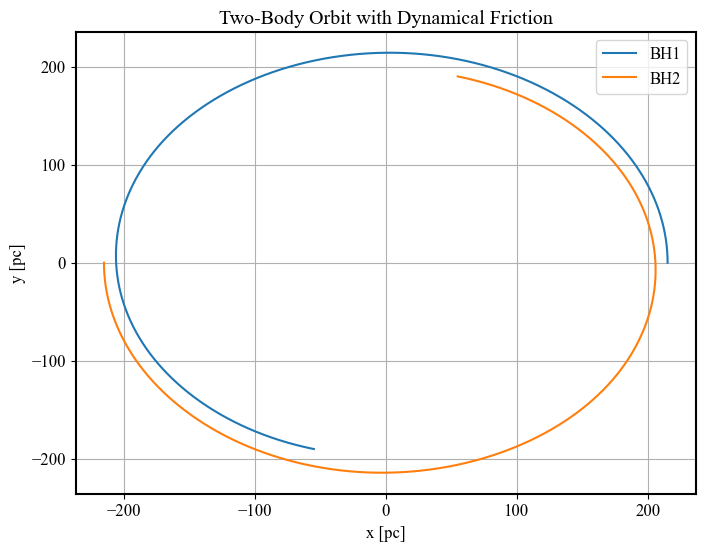

In [ ]:
def dydt(t, y, m1, m2, G, m_gal, df_on=False):
    r1 = y[0:3] * u.pc
    r2 = y[3:6] * u.pc
    v1 = y[6:9] * (u.pc/u.yr)
    v2 = y[9:12] * (u.pc/u.yr)
    

    r12 = r2 - r1
    r12_mag = np.linalg.norm(r12)
    a1_grav = (G * m2 / r12_mag**3) * r12
    a2_grav = (G * m1 / r12_mag**3) * (-r12)
    

    a1_df = np.zeros(3) * u.pc/u.yr**2
    a2_df = np.zeros(3) * u.pc/u.yr**2
    
    if df_on:
        o = velocity_dispersion(m_gal)

        ln_A1 = coulomb_logarithm(np.linalg.norm(r1), o, G, m1)
        a1_df = dynamical_friction_a(r1, v1, ln_A1, G, m1)
        
        ln_A2 = coulomb_logarithm(np.linalg.norm(r2), o, G, m2)
        a2_df = dynamical_friction_a(r2, v2, ln_A2, G, m2)
    
    a1_total = a1_grav + a1_df
    a2_total = a2_grav + a2_df
    
    return np.concatenate([
        v1.to_value(u.pc/u.yr),
        v2.to_value(u.pc/u.yr),
        a1_total.to_value(u.pc/u.yr**2),
        a2_total.to_value(u.pc/u.yr**2)
    ])

t_i = 0 * u.yr
t_f = (20* u.Myr).to(u.yr)


t_eval = np.arange(t_i.value, t_f.value + 400, 400)  #need to include tend


m1_ = m1.to_value(const.M_sun)
m2_ = m2.to_value(const.M_sun)
r1_val = r1_initial.to_value(u.pc)
r2_val = r2_initial.to_value(u.pc)


v1_val = v1_initial.to(u.pc / u.yr).value #changing this to pc/yr since at first there were problems and need to do years so that it doesnt solve per second
v2_val = v2_inital.to(u.pc / u.yr).value


# y0 = np.concatenate([r1_val, r2_val, v1_val, v2_val, a_D1_val.value, a_D2_val.value])
y0 = np.concatenate([r1_val, r2_val, v1_val, v2_val])

sol = solve_ivp(fun=lambda t, y: dydt(t, y, m1, m2, G, df_on=False),t_span=(t_i.value, t_f.value), y0=y0,t_eval=t_eval,method='RK45') #lambda was a suggestion by chatgpt as my previous attempts to switch true to false automiatcall didnt work, might need to do another swtich based on how this will develop

r1_sol = sol.y[0:3, :].T #trasnpose to get a scrolling list
r2_sol = sol.y[3:6, :].T


plt.figure(figsize=(8, 6))
plt.plot(r1_sol[:, 0], r1_sol[:, 1], label='BH1')
plt.plot(r2_sol[:, 0], r2_sol[:, 1], label='BH2')
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend()
plt.grid()
plt.title("Two-Body Orbit with Dynamical Friction")
plt.show()

In [18]:
print(r1_sol)

[[ 2.15000000e+02  0.00000000e+00  0.00000000e+00]
 [ 2.14999999e+02  1.82967826e-02  0.00000000e+00]
 [ 2.14999997e+02  3.65935650e-02  0.00000000e+00]
 ...
 [-5.49377133e+01 -1.90095119e+02  0.00000000e+00]
 [-5.49189904e+01 -1.90100189e+02  0.00000000e+00]
 [-5.49002670e+01 -1.90105257e+02  0.00000000e+00]]


In [19]:
# # region code : past for loop
# r1_sol = [r1_initial.copy()]
# r2_sol = [r2_initial.copy()]
# v1_sol = []
# v2_sol = []
# F_D1sol = []
# F_D2sol = []
# r1_mag_sol = []
# r2_mag_sol = []


# for i in range(5):

#     r1, r2, v1, v2, dv1bydt, dv2bydt = two_body(G, m1, m2, r1, r2, v1, v2, delta_t)

#     print(r1, r2)
#     # o = velocity_disp(m_gal)
#     # ln_A1, ln_A2, r1_com_mag, r2_com_mag = coulomb_log(r1, r2, r_com, o, G, m1, m2)


#     # F_D1_accel, F_D2_accel = dynamical_friction(G, m1, m2, r1_com_mag, r2_com_mag, v1, v2, ln_A1, ln_A2, v_com)


#     # dv1bydt += F_D1_accel
#     # dv2bydt += F_D2_accel


#     # v1 += dv1bydt * delta_t
#     # v2 += dv2bydt * delta_t

#     # r1 += v1 * delta_t
#     # r2 += v2 * delta_t


#     r1_mag = np.linalg.norm(r1)
#     r2_mag = np.linalg.norm(r2)

#     r1_mag_sol.append(r1_mag.value)
#     r2_mag_sol.append(r2_mag.value)

#     # F_D1sol.append(F_D1_accel.value)
#     # F_D2sol.append(F_D2_accel.value)

#     r1_sol.append(r1.value)
#     r2_sol.append(r2.value)
#     v1_sol.append(v1.value)
#     v2_sol.append(v2.value)

# time_values = np.arange(0, N) * delta_t.to(u.Myr).value  # Convert delta_t to Myr or desired unit

# r1_sol = np.array(r1_sol)
# r2_sol = np.array(r2_sol)
# v1_sol = np.array(v1_sol)
# v2_sol = np.array(v2_sol)
# # F_D1sol = np.array(F_D1sol)
# # F_D2sol = np.array(F_D2sol)
# r1_mag_sol = np.array(r1_mag_sol)
# r2_mag_sol = np.array(r2_mag_sol)



# print("Final positions (r1, r2):", r1_sol[-1], r2_sol[-1])
# print("Final velocities (v1, v2):", v1_sol[-1], v2_sol[-1])
# # print("Final dynamical friction (F_D1, F_D2):", F_D1sol[-1], F_D2sol[-1])

# # endregion     


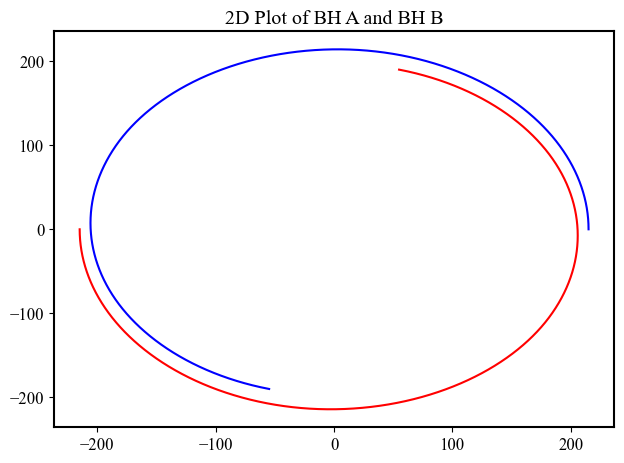

In [20]:
# region


# fig, axs = plt.subplots(1, 2, figsize=(12, 5))  


# axs[0].plot(time_values, r1_mag_sol, label="|r1|", color='b')

# axs[0].set_title("Magnitude of r1 Over Time")
# axs[0].set_xlabel("Time (Myr)")
# axs[0].set_ylabel("Distance (pc)")
# axs[0].legend()
# axs[0].grid(True)


# axs[1].plot(time_values, r2_mag_sol, label="|r2|", color='r')
# axs[1].set_title("Magnitude of r2 Over Time")
# axs[1].set_xlabel("Time (Myr)")
# axs[1].set_ylabel("Distance (pc)")
# axs[1].legend()
# axs[1].grid(True)

plt.plot(r1_sol[:, 0], r1_sol[:, 1], label="r1", color='b')
plt.plot(r2_sol[:, 0], r2_sol[:, 1], label="r2", color='r')
plt.title("2D Plot of BH A and BH B")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# endregion

*mag of velocity + separation vector

In [21]:
sep = r1_sol - r2_sol
sep_mag = np.linalg.norm(sep, axis=1)
print(sep_mag)

plt.plot(time_values, sep_mag, label="Separation")

[430.         430.         430.         ... 395.74894424 395.74829082
 395.74763749]


NameError: name 'time_values' is not defined

In [ ]:
r1_sol = np.array(r1_sol)
r2_sol = np.array(r2_sol)



finalsep = r1_sol[-1] - r2_sol[-1]

print(finalsep)

[-180374.97809745  368378.83164649       0.        ]


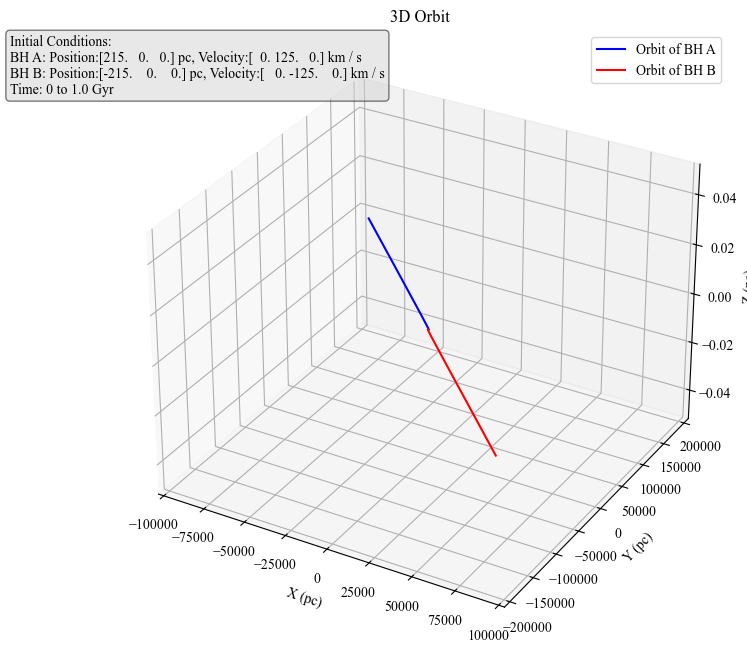

In [ ]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.plot(r1_sol[:, 0], r1_sol[:, 1], r1_sol[:, 2], label="Orbit of BH A", color="blue")


ax.plot(r2_sol[:, 0], r2_sol[:, 1], r2_sol[:, 2], label="Orbit of BH B", color="red")


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)') 
ax.set_zlabel('Z (pc)')
ax.set_title('3D Orbit')


ax.legend()

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

plt.show()

In [ ]:
r1_sol[0]

array([ 94.12866502, 484.49030989,   0.        ])

In [ ]:
sep = r2_sol[-2] - r1_sol[-2]
sep_magnitude = np.linalg.norm(sep)
print(r1_sol[-1], sep_magnitude)


[-90187.48904873 184189.41582325      0.        ] 409349.98683388426


/var/folders/rf/799sdl_537nf32dnhw741jq80000gn/T/ipykernel_63138/682720306.py:24: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


Text(0, 0.8, 'Initial Conditions:\nBH A: Position:[215.   0.   0.] pc, Velocity:[  0. 125.   0.] km / s\nBH B: Position:[-215.    0.    0.] pc, Velocity:[   0. -125.    0.] km / s\nTime: 0 to 1.0 Gyr')

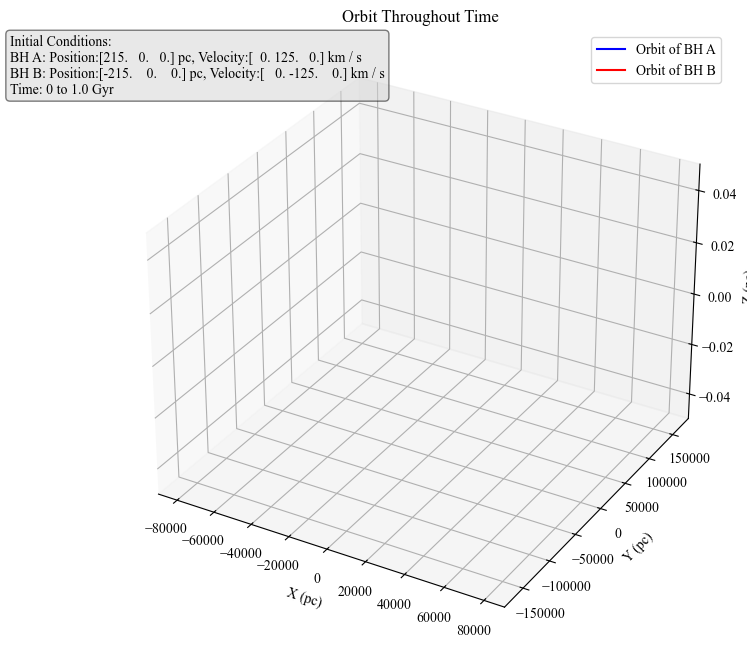

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Orbit Throughout Time')


line1, = ax.plot([], [], [], label="Orbit of BH A", color="blue")
line2, = ax.plot([], [], [], label="Orbit of BH B", color="red")
ax.legend()

# Limits for the plot (adjust as needed based on data)
ax.set_xlim([min(np.min(r1_sol[:, 0]), np.min(r2_sol[:, 0])), max(np.max(r1_sol[:, 0]), np.max(r2_sol[:, 0]))])
ax.set_ylim([min(np.min(r1_sol[:, 1]), np.min(r2_sol[:, 1])), max(np.max(r1_sol[:, 1]), np.max(r2_sol[:, 1]))])
ax.set_zlim([min(np.min(r1_sol[:, 2]), np.min(r2_sol[:, 2])), max(np.max(r1_sol[:, 2]), np.max(r2_sol[:, 2]))])


def update(num):

    line1.set_data(r1_sol[:num, 0], r1_sol[:num, 1])
    line1.set_3d_properties(r1_sol[:num, 2])
    
    line2.set_data(r2_sol[:num, 0], r2_sol[:num, 1])
    line2.set_3d_properties(r2_sol[:num, 2])
    
    return line1, line2

initial_conditions_text = (
    f"Initial Conditions:\n"
    f"BH A: Position:{r1_initial}, Velocity:{v1_initial}\n"
    f"BH B: Position:{r2_initial}, Velocity:{v2_inital}\n"
    f"Time: 0 to {T}"
)
fig.text(0, 0.8, initial_conditions_text, fontsize=10, bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.5))

# ani = FuncAnimation(fig, update, frames=len(r1_sol), interval=50, blit=True)


# plt.show()


# ani.save("J1010#6.mp4", writer="ffmpeg", fps=220)  # Adjust fps as needed

Plot of Velocities

In [ ]:
F_D1sol.shape

(500, 3)

Dynamical Friction Plot

NameError: name 'F_D1' is not defined

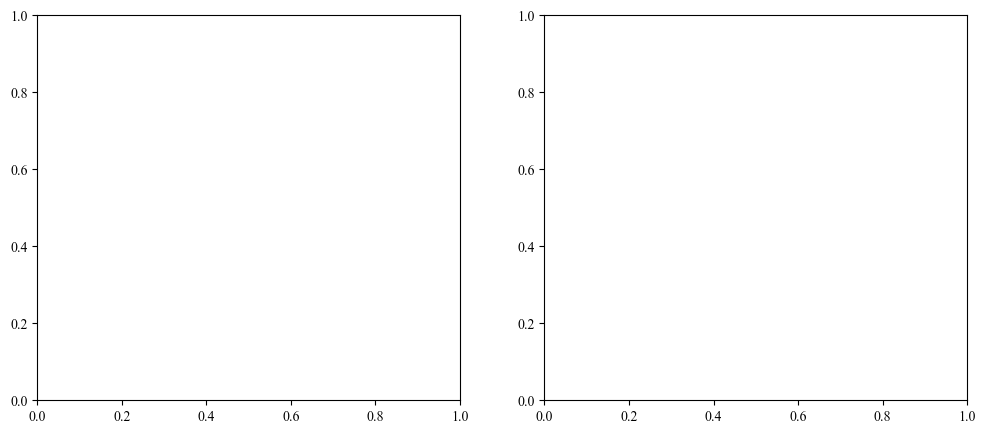

In [ ]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100]  

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

for c in c_values:
    r1_sol = []
    r2_sol = []
    v1_sol = []
    v2_sol = []
    F_D1sol = []
    F_D2sol = []


    for i in range(N):
        dv1bydt=((G*m2*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D1)
        dv2bydt=((-G*m1*(r2-r1))/r**3).to(u.km / u.s**2) + (c * F_D2) 
        v1 += dv1bydt * delta_t
        v2 += dv2bydt * delta_t

        r1 += v1.to(u.pc / u.s) * delta_t
        r2 += v2.to(u.pc / u.s) * delta_t
        # region Code Snippet 2: DF
        r1_com = r1 - r_com
        r2_com = r2 - r_com

        r1_com = np.sqrt(r1_com[0]**2 + r1_com[1]**2 + r1_com[2]**2) #we have to put the magnitude of the distance from each object from the COM
        r2_com = np.sqrt(r2_com[0]**2 + r2_com[1]**2 + r2_com[2]**2)
        

        o = ((10**(2.2969))*(m_gal/ (10**(11) * const.M_sun))**(0.299)) * (u.km/u.s)
        # region code : Coulomb Logarithm
        x1 = (np.abs(r1_com.to(u.km)) * o**(2)) / (G * m1)
        x2 = (np.abs(r2_com.to(u.km)) * o**(2)) / (G * m2)
        ln_A1 = math.log10(x1.to_value(u.dimensionless_unscaled))
        ln_A2 = math.log10(x2.to_value(u.dimensionless_unscaled))
        # endregion

        F_D1 = 0.428 * ln_A1 * ((G * m1**(2))/r1_com**(2))
        F_D2 = 0.428 * ln_A2 * ((G * m2**(2))/r2_com**(2))


        v_r1 = v1 - v_com 
        v_r2 = v2 - v_com

        v_rmag1 = np.sqrt(v_r1[0]**2 + v_r1[1]**2 + v_r1[2]**2)
        v_rmag2 = np.sqrt(v_r2[0]**2 + v_r2[1]**2 + v_r2[2]**2) #will be doing this from now on though linalg.norm does the same

        v_rel_unit1 = (v_r1 / v_rmag1)
        v_rel_unit2 = (v_r2 / v_rmag2)

        # region code: Dynamical Friction Component to Array for BH A
        F_D1_i = (F_D1 * -v_rel_unit1[0])
        F_D1_j = (F_D1 * -v_rel_unit1[1])
        F_D1_k = (F_D1 * -v_rel_unit1[2])
            
        F_D1 = np.array([F_D1_i.to((u.kg*u.m)/(u.s**2)).value, F_D1_j.to((u.kg*u.m)/ (u.s**2)).value, F_D1_k.to((u.kg*u.m)/ (u.s**2)).value])
        # endregion

        # region code: Dynamical Friction Component to Array for BH B
        F_D2_i = (F_D2 * -v_rel_unit2[0])
        F_D2_j = (F_D2 * -v_rel_unit2[1])
        F_D2_k = (F_D2 * -v_rel_unit2[2])
            
        F_D2 = np.array([F_D2_i.to((u.kg*u.m)/(u.s**2)).value, F_D2_j.to((u.kg*u.m)/ (u.s**2)).value, F_D2_k.to((u.kg*u.m)/ (u.s**2)).value])
        # endregion


        F_D1 = F_D1 * ((u.kg * u.m)/(u.s**2))
        F_D2 = F_D2 * ((u.kg * u.m)/(u.s**2))
            

        F_D1 = (F_D1 / m1).to(u.km / u.s**2)
        F_D2 = (F_D2 / m2).to(u.km / u.s**2)
        F_D1sol.append([

            (F_D1_i.to((u.kg * u.m) / (u.s**2))/m1).value,
            (F_D1_j.to((u.kg * u.m) / (u.s**2))/m1).value,
            (F_D1_k.to((u.kg * u.m) / (u.s**2))/m1).value
        ])
        F_D2sol.append([

            (F_D2_i.to((u.kg * u.m) / (u.s**2))/m2).value,
            (F_D2_j.to((u.kg * u.m) / (u.s**2))/m2).value,
            (F_D2_k.to((u.kg * u.m) / (u.s**2))/m2).value
        ])

        r1_sol.append(r1.copy())
        r2_sol.append(r2.copy())
        v1_sol.append(v1.copy())
        v2_sol.append(v2.copy())


    F_D1sol = np.array(F_D1sol)
    F_D2sol = np.array(F_D2sol)


    mag_fd1 = np.sqrt(F_D1sol[:, 0]**2 + F_D1sol[:, 1]**2 + F_D1sol[:, 2]**2)
    mag_fd2 = np.sqrt(F_D2sol[:, 0]**2 + F_D2sol[:, 1]**2 + F_D2sol[:, 2]**2)


    axs[0].plot(time_values, mag_fd1, label=f"c = {c}")
    axs[1].plot(time_values, mag_fd2, label=f"c = {c}")


axs[0].set_title("Dynamical Friction - Body 1")
axs[0].set_xlabel("Time (Myr)")
axs[0].set_ylabel("Force Magnitude (km/s²)")
axs[0].legend()

axs[1].set_title("Dynamical Friction - Body 2")
axs[1].set_xlabel("Time (Myr)")
axs[1].set_ylabel("Force Magnitude (km/s²)")
axs[1].legend()

plt.tight_layout()
plt.show()

Testing separation levels here

In [ ]:
massterm = (m1+m2)/(10**8*u.Msun)
velterm = ((200*u.km/u.s)/o)**2
dynhard_rad = (10*u.pc*massterm*velterm).to(u.pc)
print(dynhard_rad) #this is the semi-major axis for when stellar hardening takes over from DF (so sep/2)

81.5361082035837 pc


In [ ]:
r1_sol[-1]

<Quantity [  16.18987711, -150.0958428 ,    0.        ] pc>

In [ ]:
r1_sol[0]

<Quantity [  16.19420377, -150.13595521,    0.        ] pc>